In [8]:
using NextGenSeqUtils, Compose, PyPlot, Colors

┌ Info: Precompiling Compose [a81c6b42-2e10-5240-aca2-a61377ecd94b]
└ @ Base loading.jl:1278


In [41]:
function ref_diff_seq(ref1,ref2,query)
    vec = zeros(Int64,length(ref1))
    for i in 1:length(ref1)
        if query[i] != '-'
            #Match to ref1 = 1; to ref2 = 2, and neither = 3
            vec[i] = ((ref1[i] != query[i]) + (2 * (ref2[i] != query[i])))
        end
    end
    return vec
end

const colorvec = ["purple","teal","black"]

#This is a single sequence highlighter plot.
function recomb_highlighter(ref1,ref2,query; ylow = 0.0, yhigh = 1.0, lw = 1.0, opacity = 0.7)
    vec = ref_diff_seq(ref1,ref2,query)
    point_inds = collect(1:length(vec))[vec .>0];
    colorvec[vec[point_inds]]
    normalized = point_inds./length(vec)
    point_array = [((n,ylow),(n,yhigh)) for n in normalized];
    return compose(context(), line(point_array), stroke(colorvec[vec[point_inds]]), linewidth(lw),strokeopacity(opacity))
end

#This stacks those all together from a .fasta file, but with no annotation.
"""
recomb_alignment(path::String,ind1::Int64,ind2::Int64,from::Int64)
path: path to .fasta file.
ind1: index of first parent
ind2: index of second parent.
from: sequences will be displayed from this index to the end.
"""
function recomb_alignment(path::String,ind1::Int64,ind2::Int64,from::Int64)
    seqnames,seqs = read_fasta_with_names(path);
    ref1,ref2 = seqs[[ind1,ind2]];
    comp_array = [recomb_highlighter(ref1,ref2,seqs[i], ylow = (i-from)/(1 + length(seqs)-from), yhigh = ((i-from)/(1 + length(seqs)-from))+0.5/(1 + length(seqs)-from)) for i in from:length(seqs)];
    return compose(context(),comp_array)
end

#Plots a single region in its own context. Will look funky on its own.
function region_plot(alignment_length,regions; colors = ["gray","black"], lw = 0.5h, opacity = 0.5, font_size = 0.02w)
    color_arr = [colors[mod(i-1,length(colors))+1] for i in 1:length(regions)]
    point_array = [((r[1]/alignment_length,0.5),(r[2]/alignment_length,0.5)) for r in regions]
    bar_img = compose(context(0.0,0.5,1.0,0.5), line(point_array), stroke(color_arr), linewidth(lw),strokeopacity(opacity))
    text_img = compose(context(),[compose(context(), Compose.text((r[1]+r[2])/(2*alignment_length),0.25,r[3],hcenter), fontsize(font_size), font("Helvetica-Bold")) for r in regions])
    return compose(context(),text_img,bar_img)
end

function seq_coord_array(ref)
    cs = cumsum(collect(ref) .!= '-')
    zipped = collect(zip(collect(1:length(ref)),cs))
    vec = zeros(Int64,cs[end])
    for z in zipped
        vec[z[2]] = z[1]
    end
    return vec
end

#This stacks those all together from a .fasta file, with annotation.
"""
recomb_alignment(path,ind1,ind2,from,regions_degapped_coords; coord_ind = 1)
path: path to .fasta file.
ind1: index of first parent
ind2: index of second parent.
from: sequences will be displayed from this index to the end.
regions_degapped_coords: coords in the degapped numbering of the ref sequence (ref inds given by coord_ind)
"""
function highlighter_with_coords(path,ind1,ind2,from,regions_degapped_coords; coord_ind = 1)
    seqnames,seqs = read_fasta_with_names(path);
    seqs = uppercase.(seqs)
    h = length(seqs)/5
    set_default_graphic_size(10cm,h*1cm)
    
    coord_map = seq_coord_array(seqs[coord_ind])
    regions = [(coord_map[r[1]],coord_map[r[2]],r[3]) for r in regions_degapped_coords]
    ref1,ref2 = seqs[[ind1,ind2]];
    comp_array = [recomb_highlighter(ref1,ref2,seqs[i], ylow = (i-from)/(1 + length(seqs)-from), yhigh = ((i-from)/(1 + length(seqs)-from))+0.5/(1 + length(seqs)-from)) for i in from:length(seqs)];
    highlighter = compose(context(0.0,0.1,1.0,0.9),comp_array)
    region_bar = region_plot(length(ref1),regions, colors = ["gray","black"])
    annotated = compose(context(0.0,0.07,1.0,0.02),region_bar)
    img = compose(context(),highlighter,annotated)
    return img
end

highlighter_with_coords

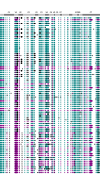

In [42]:
env_coords = [(1,34,""),
            (35,126,"C1"),
            (127,159,"V1"),
            (160,195,"V2"),
            (196,296,"C2"),
            (297,330,"V3"),
            (331,385,"C3"),
            (386,417,"V4"),
            (418,459,"C4"),
            (460,470,"V5"),
            (471,511,"C5"),
            (512,530,"FP"),
            (532,590,""),
            (591,623,""),
            (627,661,""),
            (662,680,"MPER"),
            (682,707,""),
            (708,856,"CT")];
img = highlighter_with_coords("path-to-fasta.fasta",2,3,5,env_coords); 

In [43]:
#How to save as .svg
Compose.draw(SVG("customhighlighter.svg"), img)

false